# Training an oblong food classifier

Do you ever worry about being unable to identify the difference between a spring roll, hot dog, and churro? Me neither, but let's pretend that did happen. You don't need to fear any longer because this model will try its best to tell you what it is! 

**NOTE**: Running this will take up some time! I highly reccomend running on GPU. You can change to GPU by selecting `Runtime > Change runtime type > Hardware accelerator > GPU`

### Loading and preparing the data

In [1]:
import torch
# Import PyTorch and nn 
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

!pip install -Uqq fastai 
from fastai.vision.all import *

In [9]:
# Downloading the flowers dataset: https://docs.fast.ai/data.external.html
food_path = untar_data(URLs.FOOD)

In [10]:
# Display table using Pandas to look at the categories
pd.read_json('/root/.fastai/data/food-101/test.json')

,churros,hot_and_sour_soup,samosa,sashimi,pork_chop,spring_rolls,panna_cotta,beef_tartare,greek_salad,foie_gras,...,chicken_quesadilla,pho,prime_rib,cheesecake,ice_cream,omelette,grilled_cheese_sandwich,lobster_roll_sandwich,nachos,oysters
0,churros/1061830,hot_and_sour_soup/1000486,samosa/1009326,sashimi/100113,pork_chop/1012227,spring_rolls/1005480,panna_cotta/1006650,beef_tartare/101073,greek_salad/1010850,foie_gras/1007306,...,chicken_quesadilla/10257,pho/1002382,prime_rib/1006976,cheesecake/1023543,ice_cream/1004744,omelette/1019294,grilled_cheese_sandwich/1000938,lobster_roll_sandwich/1002698,nachos/1011831,oysters/1005672
1,churros/1064042,hot_and_sour_soup/1004564,samosa/1024186,sashimi/1017182,pork_chop/1019077,spring_rolls/103010,panna_cotta/1027460,beef_tartare/1029120,greek_salad/1029680,foie_gras/1044237,...,chicken_quesadilla/1030292,pho/1020153,prime_rib/102197,cheesecake/102854,ice_cream/1031536,omelette/1058816,grilled_cheese_sandwich/1003050,lobster_roll_sandwich/1029665,nachos/101954,oysters/1017801
2,churros/1074903,hot_and_sour_soup/1011278,samosa/1036216,sashimi/1043094,pork_chop/102958,spring_rolls/1036175,panna_cotta/1030883,beef_tartare/1030025,greek_salad/1053670,foie_gras/1073688,...,chicken_quesadilla/1052529,pho/1026354,prime_rib/102813,cheesecake/1073148,ice_cream/1075106,omelette/1116874,grilled_cheese_sandwich/1005927,lobster_roll_sandwich/103891,nachos/103312,oysters/1019666
3,churros/1085259,hot_and_sour_soup/1029400,samosa/103689,sashimi/1050391,pork_chop/1040432,spring_rolls/1044858,panna_cotta/103712,beef_tartare/1031053,greek_salad/1062715,foie_gras/1113614,...,chicken_quesadilla/1096804,pho/1028507,prime_rib/1035695,cheesecake/1092082,ice_cream/1100243,omelette/1122818,grilled_cheese_sandwich/100694,lobster_roll_sandwich/104300,nachos/1044020,oysters/1040557
4,churros/1097261,hot_and_sour_soup/1044215,samosa/1052427,sashimi/10551,pork_chop/1045605,spring_rolls/1067952,panna_cotta/1050629,beef_tartare/1066933,greek_salad/1101710,foie_gras/1125178,...,chicken_quesadilla/1102036,pho/1029709,prime_rib/105375,cheesecake/1096018,ice_cream/1106165,omelette/1145379,grilled_cheese_sandwich/1052563,lobster_roll_sandwich/1046809,nachos/1060157,oysters/1044823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,churros/904526,hot_and_sour_soup/963551,samosa/917040,sashimi/889209,pork_chop/92293,spring_rolls/949343,panna_cotta/97960,beef_tartare/926143,greek_salad/949442,foie_gras/953456,...,chicken_quesadilla/921154,pho/964800,prime_rib/940800,cheesecake/970606,ice_cream/880755,omelette/955537,grilled_cheese_sandwich/942123,lobster_roll_sandwich/91688,nachos/962352,oysters/967284
246,churros/937430,hot_and_sour_soup/968546,samosa/929017,sashimi/893381,pork_chop/929555,spring_rolls/950371,panna_cotta/980326,beef_tartare/948352,greek_salad/961722,foie_gras/961263,...,chicken_quesadilla/924555,pho/965012,prime_rib/941938,cheesecake/972877,ice_cream/891533,omelette/97045,grilled_cheese_sandwich/942187,lobster_roll_sandwich/931310,nachos/98976,oysters/967288
247,churros/938480,hot_and_sour_soup/982582,samosa/937665,sashimi/938288,pork_chop/934946,spring_rolls/951951,panna_cotta/981405,beef_tartare/956509,greek_salad/968471,foie_gras/982330,...,chicken_quesadilla/9290,pho/982022,prime_rib/956130,cheesecake/996516,ice_cream/923525,omelette/978714,grilled_cheese_sandwich/975531,lobster_roll_sandwich/946365,nachos/99050,oysters/978125
248,churros/95272,hot_and_sour_soup/984258,samosa/960937,sashimi/981801,pork_chop/942955,spring_rolls/990689,panna_cotta/98261,beef_tartare/976175,greek_salad/995103,foie_gras/98353,...,chicken_quesadilla/94597,pho/990037,prime_rib/958647,cheesecake/996918,ice_cream/995145,omelette/979117,grilled_cheese_sandwich/977481,lobster_roll_sandwich/962425,nachos/99088,oysters/978925


In [4]:
# Set the labels as the foods we want to classify 
hot_dog = 'hot_dog'
spring_rolls = 'spring_rolls'
churros = 'churros'

### Data prep and some cleaning up

This function has 2 main roles:

1.   Remove all the images that don't have *hot dog*, *churro*, or *spring rolls*. 
2.   Rename sashimi or spring roll images to have that in their filename for easier usage.



In [5]:
for img in get_image_files(food_path):
  # rename the correct images to have the label name 
  if hot_dog in str(img):
    img.rename(f"{img.parent}/{hot_dog}-{img.name}")
  elif spring_rolls in str(img):
    img.rename(f"{img.parent}/{spring_rolls}-{img.name}")
  # If the images don't fit in those categories, remove img
  elif churros in str(img):
    img.rename(f"{img.parent}/{churros}-{img.name}")
  else:
    os.remove(img)

# Training the model

In [6]:
def getLabel(fileName):
  return fileName.split('-')[0]

# Testing getLabel function 
# ---------------------------

# getLabel("sashimi-100113.jpg")
#getLabel("spring_rolls-100113.jpg")

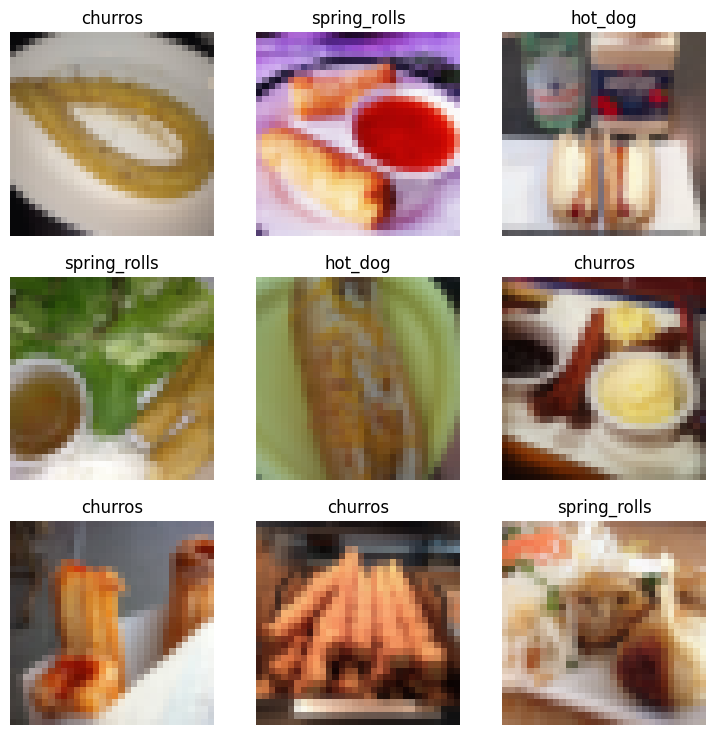

In [7]:
dls = ImageDataLoaders.from_name_func(
    food_path, get_image_files(food_path), valid_pct=0.2, seed=420,
    label_func=getLabel, item_tfms=Resize(32))

dls.train.show_batch()

# Convolutional neural network

In [8]:
learn = cnn_learner(dls, resnet34, metrics=error_rate, pretrained=True)
learn.fine_tune(epochs=1)

/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593

epoch,train_loss,valid_loss,error_rate,time
0,1.730384,1.126137,0.483333,00:26


epoch,train_loss,valid_loss,error_rate,time
0,1.376831,1.168608,0.480000,00:19


# Verify model

### Test the model using uploaded images

Saving sample3.jpg to sample3.jpg


This is most likely hot_dog.


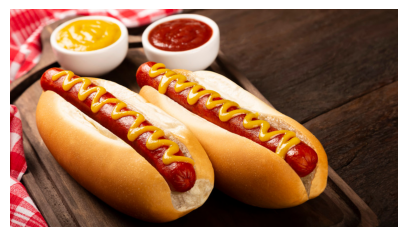

In [11]:
from google.colab import files
input_img = files.upload()

for img in input_img.items():
  uploaded_img = img[0]
img = PILImage.create(uploaded_img)
img.show()

label,_,probs = learn.predict(img)

print(f"This is most likely {label}.")

# Find the accuracy using confusion matrix
[More about this here](https://deepchecks.com/how-to-check-the-accuracy-of-your-machine-learning-model/#:~:text=Accuracy%20score%20in%20machine%20learning%20is%20an%20evaluation%20metric%20that,the%20total%20number%20of%20predictions.)

How to improve ML model accuracy:
TODO: do your research
1.   List item
2.   List item



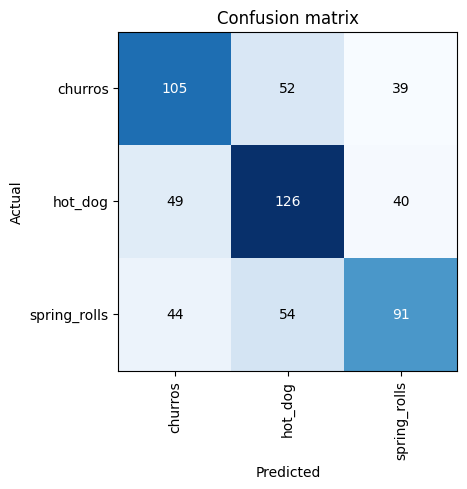

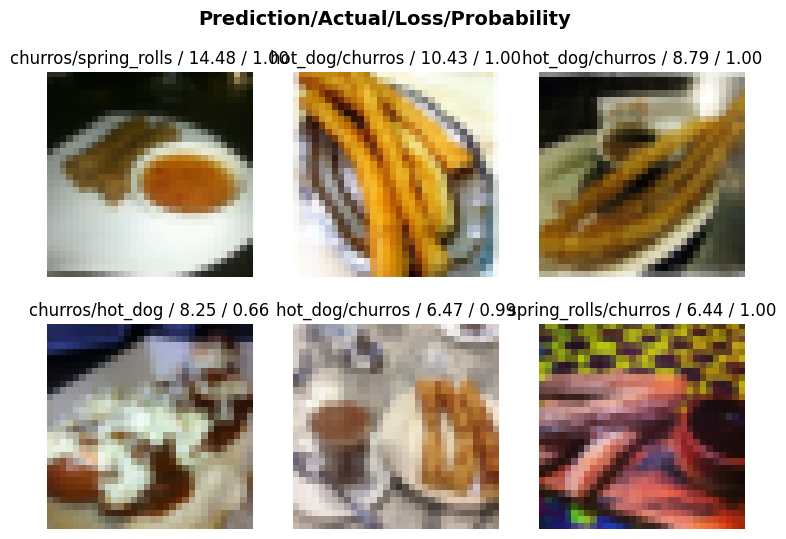

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.plot_top_losses(6)

### Next steps

I plan to deploy this using Docker for easier audience usage. 

### Deploy

In [ ]:
# Export model as .pkl file
learn.export()

In [ ]:
model_path = get_files(food_path, '.pkl')[0]
model_path

Path('/root/.fastai/data/food-101/export.pkl')

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

learn_inf = load_learner(model_path)
learn_inf.predict(mpimg.imread(get_image_files(food_path)[0])) #raw prediction

('spring_rolls', tensor(2), tensor([0.1191, 0.2776, 0.6032]))

In [ ]:
# Get labels
learn_inf.dls.vocab

['churros', 'hot_dog', 'spring_rolls']

In [ ]:
from google.colab import files
files.download(model_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>